# Parameter estimation using censored data

This Notebook explains the use of censored data for parameter estimation of ODE models.
An example model is provided in `pypesto/doc/example/example_censored`. 
The implementation supports all three censoring types of measurements:

- Left censored: a datapoint is below a certain known value.
- Right censored: a datapoint is above a certain known value.
- Interval censored: a datapoint is on an interval between two known values.

In all three cases, the exact numerical value of the datapoint is unknown. For the integration of censored measurements, we employ the optimal scaling approach. In this approach, each datapoint is represented by a variable surrogate datapoint which is constrained to be in its respective category. Categories can be thought of as intervals with specific bounds. 

For censored data, the category bounds are already known from the censoring value:

- for left censored data the category bounds are (0, censoring value),
- for right censored data the category bounds are (censoring value, infinity),
- for interval censored data the category bounds are given by the interval bounds.

This makes the identification of surrogate data extremely simple, as it can be directly (analytically) calculated.

Details on the optimal scaling approach can be found in Shepard, 1962 (https://doi.org/10.1007/BF02289621).
Details on the application of the gradient-based optimal scaling approach to mechanistic modeling
with ordinal data can be found in Schmiester et al. 2020 (https://doi.org/10.1007/s00285-020-01522-w)
and Schmiester et al. 2021 (https://doi.org/10.1093/bioinformatics/btab512).

## Import model from the petab_problem

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import petab

import pypesto
import pypesto.logging
import pypesto.optimize as optimize
from pypesto.petab import PetabImporter
from pypesto.visualize import plot_categories_from_pypesto_result

To use censored data for parameter estimation, in pyPESTO we use the optimal scaling approach. Since the optimal scaling approach is implemented in the hierarchical manner, it requires us to specify `hierarchical=True` when importing the `petab_problem`:

In [2]:
petab_folder = './example_censored/'
yaml_file = 'example_censored.yaml'

petab_problem = petab.Problem.from_yaml(petab_folder + yaml_file)

importer = PetabImporter(petab_problem, hierarchical=True)

The `petab_problem` has to be specified in the usual PEtab formulation. The censored measurements have to be specified in the `measurement.tsv` file by adding the censoring type in the `measurementType` column, where a censoring type can be:

- `left-censored`,
- `right-censored`,
- or `interval-censored`.

If the censoring type is not specified, the measurement will be considered as quantitative. Then, the censoring bound has to be specified in the `censoringBounds` column. For interval censored measurements the bounds should be separated with a semicolon:

In [3]:
from pandas import option_context

with option_context('display.max_colwidth', 400):
    display(petab_problem.measurement_df)

,observableId,preequilibrationConditionId,simulationConditionId,measurement,time,observableParameters,noiseParameters,observableTransformation,noiseDistribution,measurementType,censoringBounds
0,Activity,NaN,Inhibitor_0,0.000000,5,NaN,1,lin,normal,interval-censored,10.0;16.0
1,Activity,NaN,Inhibitor_3,0.000000,5,NaN,1,lin,normal,interval-censored,10.0;16.0
2,Activity,NaN,Inhibitor_10,17.892654,5,NaN,1,lin,normal,NaN,NaN
3,Activity,NaN,Inhibitor_25,0.000000,5,NaN,1,lin,normal,right-censored,20.0
4,Activity,NaN,Inhibitor_35,16.812104,5,NaN,1,lin,normal,NaN,NaN
5,Activity,NaN,Inhibitor_50,9.173129,5,NaN,1,lin,normal,NaN,NaN
6,Activity,NaN,Inhibitor_75,4.150928,5,NaN,1,lin,normal,NaN,NaN
7,Activity,NaN,Inhibitor_100,0.000000,5,NaN,1,lin,normal,left-censored,3.0
8,Activity,NaN,Inhibitor_300,0.000000,5,NaN,1,lin,normal,left-censored,3.0
9,Ybar,NaN,Inhibitor_0,0.000000,5,NaN,1,lin,normal,NaN,NaN


For censored measurements, the `measurement` column will be ignored. For the `Ybar` observable we didn't specify a measurement type, so those will be used as quantitative.

#### Note on inclusion of additional data types:
It is possible to include observables with different types of data to the same `petab_problem`. Refer to the notebooks on using [nonlinear-monotone data](nonlinear_monotone.ipynb) and [ordinal data](ordinal.ipynb) for details on integration of other data types. Additionally, as shown in this example, if the `measurementType` column is left empty for all measurements of an observable, the observable will be treated as quantitative.

## Construct the objective and pypesto problem

Now when we construct the `objective`, it will construct all objects of the optimal scaling inner optimization:

- `OptimalScalingInnerSolver`
- `OptimalScalingAmiciCalculator`
- `OptimalScalingProblem`

As there are no censored data specific inner options, we will pass none to the constructor.

In [4]:
objective = importer.create_objective()

Now let's construct the pyPESTO problem and optimizer. We're going to use a gradint-based optimizer for a faster optimization, but gradient-free optimizers can be used in the same way:

In [5]:
problem = importer.create_problem(objective)

engine = pypesto.engine.SingleCoreEngine()

optimizer = optimize.ScipyOptimizer(
    method="L-BFGS-B",
    options={"disp": None, "ftol": 2.220446049250313e-09, "gtol": 1e-5},
)
n_starts = 10
np.random.seed(n_starts)

## Run optimization using optimal scaling approach

In [6]:
np.random.seed(n_starts)

res = optimize.minimize(
    problem, n_starts=n_starts, optimizer=optimizer, engine=engine
)

100%|██████████| 10/10 [00:18<00:00,  1.83s/it]


## Visualizing the result

<AxesSubplot: title={'center': 'Waterfall plot'}, xlabel='Ordered optimizer run', ylabel='Objective value (offset=-1.554e+01)'>

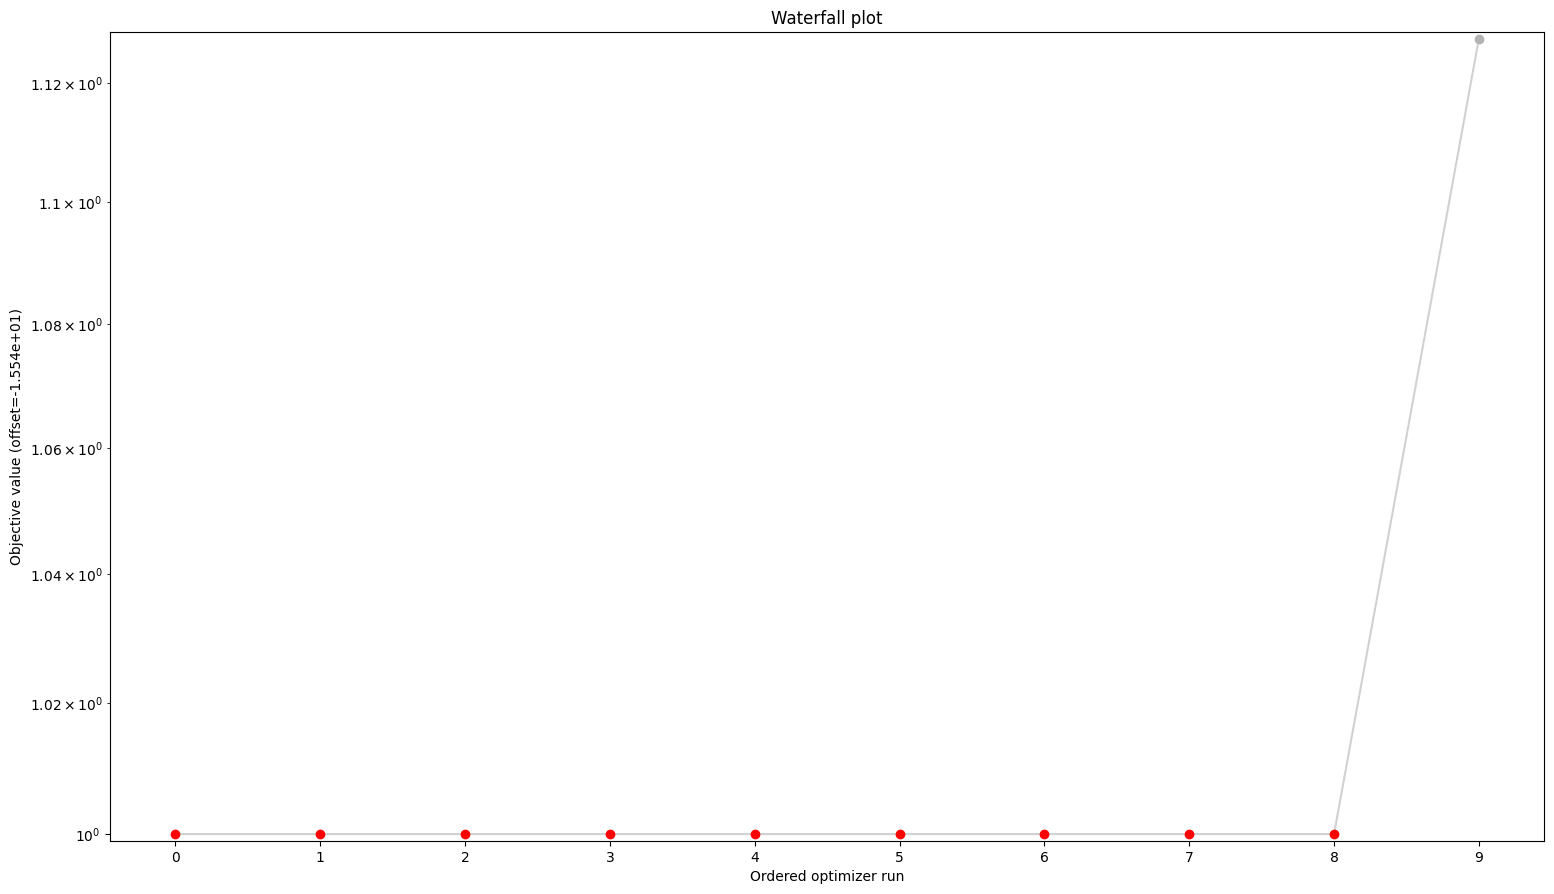

In [7]:
from pypesto.visualize import waterfall

waterfall(res)

We can plot the censoring categories using the `plot_categories_from_pypesto_result` plotting function.

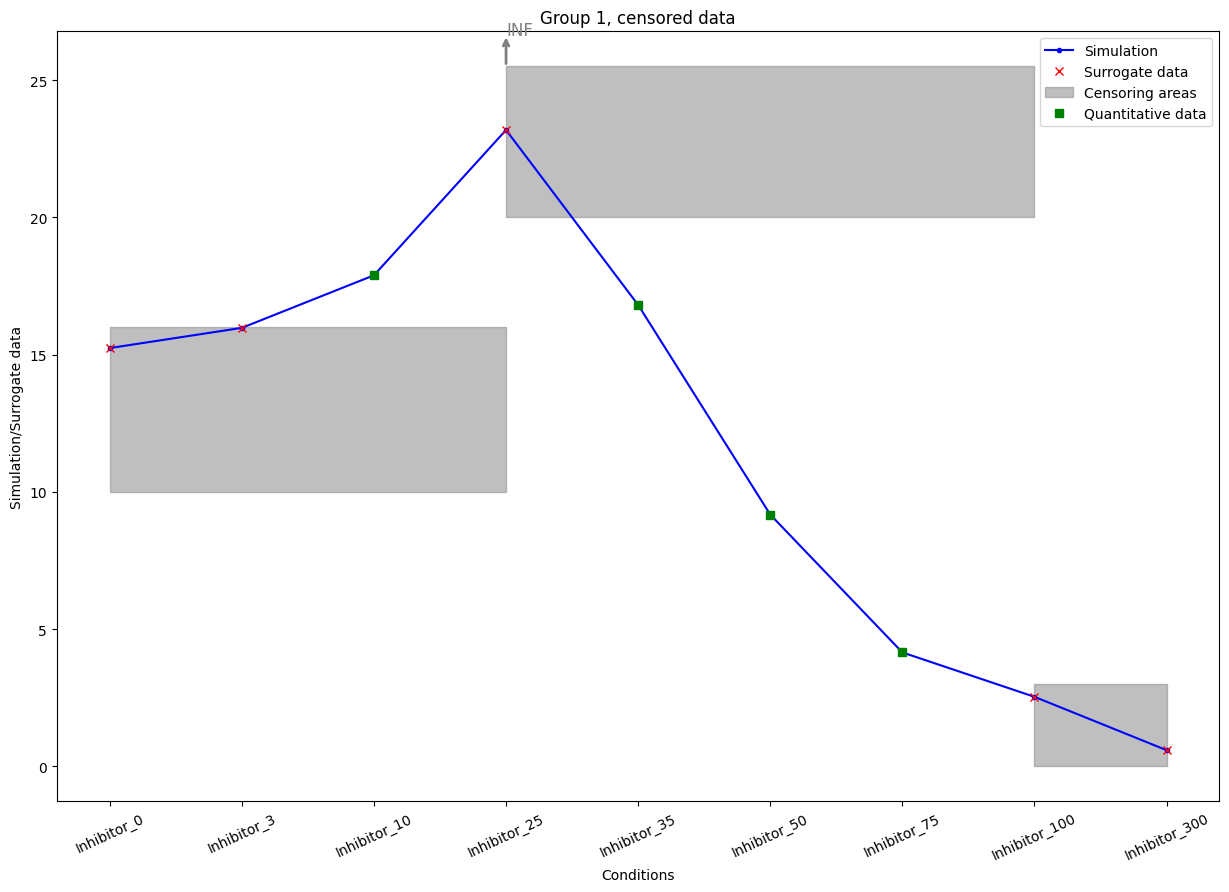

In [8]:
plot_categories_from_pypesto_result(res, figsize=(15, 10))
plt.show()